In [ ]:
#imports
import pandas as pd
import os

import numpy as np
import pandas as pd

import datetime
import time

import random

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Simulation

## Assumptions:
1. All Transactions are among Safaricom subscribers.
2. All Transactions are offline

#### Customer Features
- National ID
- Phone Number - Safaricom number used to transact
- Location - Where the transaction is from. It is a pair of coordinates to describe the location better.
- Mean Spending Frequency - Average MPESA transactions made by a user per day. Assuming that the number of transactions per day follows a Poisson distribution. This number will be drawn from a uniform distribution (0,4).
- Mean Spending Amount - The mean and standard deviation of the transaction amounts for the customer, assuming that the transaction amounts follow a normal distribution. The mean_amount will be drawn from a uniform distribution (5,100) and the std_amount will be set as the mean_amount divided by two.
- IMEI - International Mobile Equipment Identifier; 15 digit code to identify the device transacting.

### Generating Customer Profile / Entity

In [ ]:
def generate_customer_profiles_table(n_customers, random_state=0):

    np.random.seed(random_state) #consistent random values

    customer_id_properties=[]

    # Generate customer properties from random distributions
    for customer_id in range(n_customers):

        unique_digits = np.random.permutation(range(10))# generate 0-9

        national_id = ''.join(map(str, unique_digits[:8])) #first 8
        imei = random.randint(10**14, 10**15 - 1)
        phone_number = "07" + ''.join(map(str, unique_digits[:8]))

        #Location
        x_customer_location = np.random.uniform(0,100)
        y_customer_location = np.random.uniform(0,100)

        #Spending amount
        mean_amount = np.random.uniform(5,100)
        std_amount = mean_amount/2

        # Transactions per day/ frequency
        mean_tx_per_day = np.random.uniform(0,4)

        customer_id_properties.append([
                                      national_id,
                                      phone_number,
                                      x_customer_location, y_customer_location,
                                      mean_amount, std_amount,
                                      mean_tx_per_day,
                                      imei])

    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=[
                                                                            'NATIONAL_ID',
                                                                            'PHONE_NUMBER',
                                                                      'X_CUSTOMER_LXN', 'Y_CUSTOMER_LXN',
                                                                      'MEAN_AMOUNT', 'STD_AMOUNT',
                                                                      'MEAN_TX_PER_DAY',
                                                                      'IMEI'])

    return customer_profiles_table

In [ ]:
n_customers = 5
customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
customer_profiles_table

,NATIONAL_ID,PHONE_NUMBER,X_CUSTOMER_LXN,Y_CUSTOMER_LXN,MEAN_AMOUNT,STD_AMOUNT,MEAN_TX_PER_DAY,IMEI
0,28491673,0728491673,43.758721,89.177300,96.547962,48.273981,1.533766,151992014651735
1,52341098,0752341098,33.739616,64.817187,39.982946,19.991473,3.828621,939325266500907
2,64857193,0764857193,63.992102,14.335329,94.743547,47.371774,2.087393,646620396824981
3,19052863,0719052863,13.521817,32.414101,19.219112,9.609556,0.889286,708806560569514
4,85370629,0785370629,6.022547,66.676672,68.710598,34.355299,0.841530,553609413631828


#### Transaction Features
- Ref_Number - A unique identifier for the transaction
- TX_DateTime - Date and time at which the transaction occurs
- Customer_ID - The identifier for the customer. Each customer has a unique identifier
- TX_Amount - The amount of the transaction(Modelled by a Normal distribution; the amount is continuous data that is symmetrically distributed around its mean.)
- TX_Label - A binary variable, with the value 0 for a legitimate transaction, or the value 1 for a fraudulent transaction.

### Generating Transactions Features / Entity

In [ ]:
def generate_transactions_table(customer_profile, start_date = "2023-06-01", nb_days = 10):

    customer_transactions = []

    # using the National_ID from the customer_profile as the seed for both the standard random module and the NumPy library's random module.
    # ensuring that any random numbers generated using these modules will be the same for a specific customer with a given National_ID
    # every time one runs the program
    random.seed(int(customer_profile.NATIONAL_ID))
    np.random.seed(int(customer_profile.NATIONAL_ID))

    # For all days
    for day in range(nb_days):

        # Random number of transactions for that day
        nb_tx = np.random.poisson(customer_profile.MEAN_TX_PER_DAY)

        # If nb_tx positive, let us generate transactions
        if nb_tx>0:

            for tx in range(nb_tx):

                # Time of transaction: Around noon, std 20000 seconds(5hours). This choice aims at simulating the fact that
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))

                # If transaction time between 0 and 86400(0-24hours), let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):

                    # absolute Amount is drawn from a normal distribution
                    amount = np.abs(np.random.normal(customer_profile.MEAN_AMOUNT, customer_profile.STD_AMOUNT))
                    amount=np.round(amount,decimals=2)
                    # Generate IMEI for each transaction
                    transactions_df['IMEI'] = [random.randint(10**14, 10**15 - 1) for _ in range(len(transactions_df))]

                    customer_transactions.append([time_tx+day*86400, day,
                                                 customer_profile.NATIONAL_ID,
                                                amount])

    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'NATIONAL_ID', 'TX_AMOUNT'])

    if len(customer_transactions)>0:
         #Converts the TX_TIME_SECONDS column to a datetime format based on the start_date provided.
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','NATIONAL_ID','TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]

    return customer_transactions

#### Transaction for 1 customer in 5 days

In [ ]:
transaction_table_customer_0=generate_transactions_table(customer_profiles_table.iloc[0],
                                                         start_date = "2023-06-01",
                                                         nb_days = 5)
transaction_table_customer_0

,TX_DATETIME,NATIONAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2023-06-02 15:00:47,28491673,137.94,140447,1
1,2023-06-03 16:14:39,28491673,117.67,231279,2
2,2023-06-04 21:48:36,28491673,83.28,337716,3
3,2023-06-05 16:44:25,28491673,136.06,405865,4
4,2023-06-05 11:27:50,28491673,107.18,386870,4
5,2023-06-05 17:09:54,28491673,95.34,407394,4


#### Generate transactions for all customers in `customer_profile_table`. This gives us a set of 30 transactions, by 5 customers in 5 days.

In [ ]:
transactions_df=customer_profiles_table.groupby('NATIONAL_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=5)).reset_index(drop=True)
transactions_df


,TX_DATETIME,NATIONAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2023-06-03 09:22:14,19052863,20.31,206534,2
1,2023-06-02 15:00:47,28491673,137.94,140447,1
2,2023-06-03 16:14:39,28491673,117.67,231279,2
3,2023-06-04 21:48:36,28491673,83.28,337716,3
4,2023-06-05 16:44:25,28491673,136.06,405865,4
5,2023-06-05 11:27:50,28491673,107.18,386870,4
6,2023-06-05 17:09:54,28491673,95.34,407394,4
7,2023-06-01 02:39:24,52341098,32.44,9564,0
8,2023-06-01 17:21:13,52341098,4.75,62473,0
9,2023-06-01 01:31:47,52341098,31.04,5507,0


In [ ]:
def generate_dataset(n_customers = 100, nb_days=90):

    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))

    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('NATIONAL_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))

    # Sort transactions chronologically wrt to time
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # REF NUMBER are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'REFERENCE NUMBER'}, inplace = True)

    return (customer_profiles_table, transactions_df)

In [ ]:
(customer_profiles_table, transactions_df)=\
    generate_dataset(n_customers = 1000,
                     nb_days=100
                     )

Time to generate customer profiles table: 0.089s
Time to generate transactions: 4e+01s


### A total of 17836 transactions were generated from 1000 customers

In [ ]:
transactions_df.shape

(195697, 6)

In [ ]:
transactions_df.head()

,REFERENCE NUMBER,TX_DATETIME,NATIONAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,0,2023-06-01 00:00:25,31087946,24.74,25,0
1,1,2023-06-01 00:05:19,19054867,46.81,319,0
2,2,2023-06-01 00:07:37,74832516,14.92,457,0
3,3,2023-06-01 00:09:13,69437081,146.04,553,0
4,4,2023-06-01 00:16:49,03721845,11.24,1009,0


In [ ]:
%%capture

distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=1000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=1000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

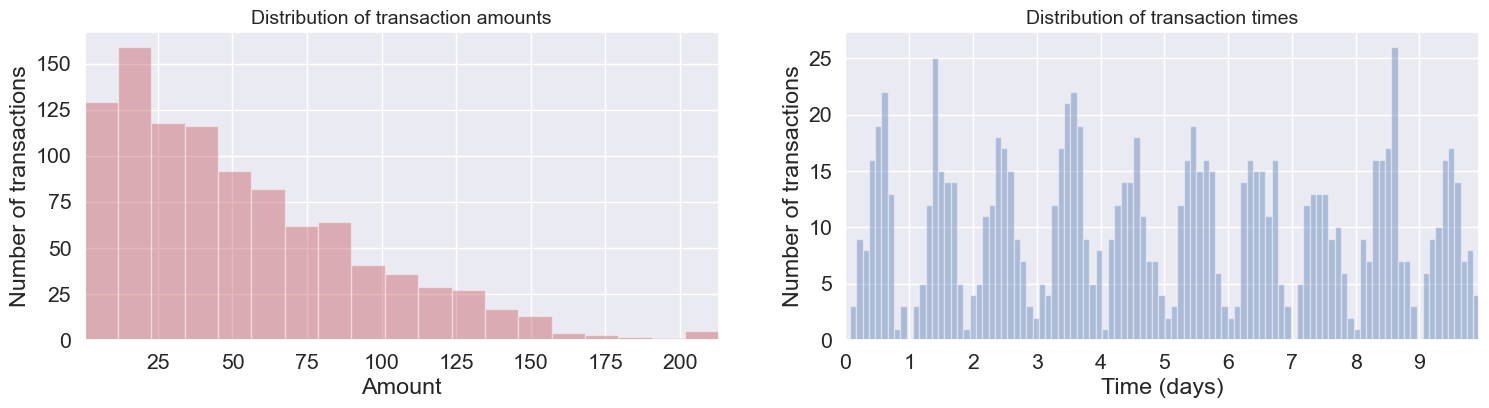

In [ ]:
distribution_amount_times_fig

### Simulating Frauds
#### Examples of fraudulent transactions can be:
- Case I: A user transacting more than 220
- Case II: Transacting from same number but different IMEI numbers
- Case III: Leaked customer credentials are exploited by a fraudster to conduct high-value fraudulent transactions alongside the legitimate transactions made by the actual customer. Detecting such fraudulent activity involves tracking and analyzing customer spending habits to identify suspicious patterns
-


In [ ]:
def add_frauds(customer_profiles_table, transactions_df):

    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0

    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))

    # Scenario 2
    # Calculate the most frequently used IMEI for each customer
    customer_profiles_table['FREQUENT_IMEI'] = customer_profiles_table.groupby('NATIONAL_ID')['IMEI'].transform(lambda x: x.value_counts().index[0])
    # Merge the frequent IMEI from the customer_profiles_table into the transactions_df
    transactions_df = pd.merge(transactions_df, customer_profiles_table[['NATIONAL_ID', 'FREQUENT_IMEI']], on='NATIONAL_ID', how='left')

     # Function to generate a random IMEI that is different from the input IMEI
    def generate_different_imei(original_imei):
      while True:
        new_imei = random.randint(10**14, 10**15 - 1)
        if new_imei != original_imei:
            return new_imei

    # Select random customers to compromise their IMEI
    random_customers = customer_profiles_table.sample(n=5)

    # Update the customer_profiles_table with the new IMEIs for the compromised customers
    for index, row in random_customers.iterrows():
      compromised_customer_id = row['NATIONAL_ID']
      frequent_imei = row['FREQUENT_IMEI']
      new_imei = generate_different_imei(frequent_imei)
      customer_profiles_table.loc[customer_profiles_table['NATIONAL_ID'] == compromised_customer_id, 'IMEI'] = new_imei

    # Merge the updated customer_profiles_table back into the transactions_df to copy the IMEI values
    transactions_df = pd.merge(transactions_df, customer_profiles_table[['NATIONAL_ID', 'IMEI']], on='NATIONAL_ID', how='left')

    # Flag transactions as fraud if the IMEI used is different from the most frequently used IMEI
    transactions_df['TX_FRAUD'] = (transactions_df['IMEI'] != transactions_df['FREQUENT_IMEI']).astype(int)

    transactions_df.loc[transactions_df['TX_FRAUD'] == 1, 'TX_FRAUD_SCENARIO'] = 2
    nb_frauds_scenario_2 = transactions_df[transactions_df['TX_FRAUD_SCENARIO'] == 2].TX_FRAUD.sum()
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))


    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):

        compromised_customers = customer_profiles_table.NATIONAL_ID.sample(n=3, random_state=day).values

        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) &
                                                    (transactions_df.TX_TIME_DAYS<day+14) &
                                                    (transactions_df.NATIONAL_ID.isin(compromised_customers))]

        nb_compromised_transactions=len(compromised_transactions)


        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))

        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3


    nb_frauds_scenario_3=transactions_df[transactions_df['TX_FRAUD_SCENARIO'] == 3].TX_FRAUD.sum()
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))

    return transactions_df

In [ ]:
%time transactions_df = add_frauds(customer_profiles_table, transactions_df)

Number of frauds from scenario 1: 137
Number of frauds from scenario 2: 1322
Number of frauds from scenario 3: 2573
CPU times: total: 4.45 s
Wall time: 4.46 s


In [ ]:
transactions_df.TX_FRAUD.mean()

0.019709039995503254

In [ ]:
transactions_df.TX_FRAUD.sum()

3857

In [ ]:
transactions_df.head()

,REFERENCE NUMBER,TX_DATETIME,NATIONAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,FREQUENT_IMEI,IMEI
0,0,2023-06-01 00:00:25,31087946,24.74,25,0,0,0,639332062852626,639332062852626
1,1,2023-06-01 00:05:19,19054867,46.81,319,0,0,0,112270595733295,112270595733295
2,2,2023-06-01 00:07:37,74832516,14.92,457,0,0,0,889581141149325,889581141149325
3,3,2023-06-01 00:09:13,69437081,146.04,553,0,0,0,240775090096496,240775090096496
4,4,2023-06-01 00:16:49,03721845,11.24,1009,0,0,0,319087217378488,319087217378488


In [ ]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==1].shape

(134, 10)

In [ ]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==2].shape

(1284, 10)

In [ ]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==3].shape

(2573, 10)

In [ ]:
DIR_OUTPUT = "./simulated-data-raw/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2023-06-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):

    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')

    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'

    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

### Date-Time Transformations into numerical variables

In [ ]:
def is_weekend(tx_datetime):

    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5

    return int(is_weekend)

In [ ]:
%time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)

CPU times: total: 969 ms
Wall time: 1.12 s


In [ ]:
def is_night(tx_datetime):

    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6

    return int(is_night)

In [ ]:
%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

CPU times: total: 219 ms
Wall time: 247 ms


In [ ]:
transactions_df[transactions_df.TX_TIME_DAYS>=30]

,REFERENCE NUMBER,TX_DATETIME,NATIONAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,FREQUENT_IMEI,IMEI,TX_DURING_WEEKEND,TX_DURING_NIGHT
58477,58477,2023-07-01 00:14:18,25930784,16.65,2592858,30,0,0,991160464868412,991160464868412,1,1
58478,58478,2023-07-01 00:22:55,37904261,46.86,2593375,30,0,0,527676280894109,527676280894109,1,1
58479,58479,2023-07-01 00:27:43,64279183,32.44,2593663,30,0,0,303242183849371,303242183849371,1,1
58480,58480,2023-07-01 00:29:36,85614732,52.76,2593776,30,0,0,580160332957613,580160332957613,1,1
58481,58481,2023-07-01 00:33:08,57681923,31.28,2593988,30,0,0,171597747831262,171597747831262,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
195692,195692,2023-09-08 23:28:40,15392670,20.69,8638120,99,0,0,465055556631071,465055556631071,0,0
195693,195693,2023-09-08 23:29:43,15392670,9.70,8638183,99,0,0,465055556631071,465055556631071,0,0
195694,195694,2023-09-08 23:31:16,41759082,104.88,8638276,99,0,0,406520351948027,406520351948027,0,0
195695,195695,2023-09-08 23:32:17,49862317,10.82,8638337,99,0,0,154853718950008,154853718950008,0,0


In [ ]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):

    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')

    # The transaction date and time is set as the index, which will allow the use of the rolling function
    customer_transactions.index=customer_transactions.TX_DATETIME

    # For each window size
    for window_size in windows_size_in_days:

        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()

        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW

        # Save feature values
        customer_transactions['NATIONAL_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['NATIONAL_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)

    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions['REFERENCE NUMBER']

    # And return the dataframe with the new features
    return customer_transactions

In [ ]:
spending_behaviour_customer_0=get_customer_spending_behaviour_features(transactions_df)
spending_behaviour_customer_0

,REFERENCE NUMBER,TX_DATETIME,NATIONAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,FREQUENT_IMEI,IMEI,TX_DURING_WEEKEND,TX_DURING_NIGHT,NATIONAL_ID_NB_TX_1DAY_WINDOW,NATIONAL_ID_AVG_AMOUNT_1DAY_WINDOW,NATIONAL_ID_NB_TX_7DAY_WINDOW,NATIONAL_ID_AVG_AMOUNT_7DAY_WINDOW,NATIONAL_ID_NB_TX_30DAY_WINDOW,NATIONAL_ID_AVG_AMOUNT_30DAY_WINDOW
REFERENCE NUMBER,,,,,,,,,,,,,,,,,,
0,0,2023-06-01 00:00:25,31087946,24.74,25,0,0,0,639332062852626,639332062852626,0,1,1.0,24.740000,1.0,24.740000,1.0,24.740000
1,1,2023-06-01 00:05:19,19054867,46.81,319,0,0,0,112270595733295,112270595733295,0,1,2.0,35.775000,2.0,35.775000,2.0,35.775000
2,2,2023-06-01 00:07:37,74832516,14.92,457,0,0,0,889581141149325,889581141149325,0,1,3.0,28.823333,3.0,28.823333,3.0,28.823333
3,3,2023-06-01 00:09:13,69437081,146.04,553,0,0,0,240775090096496,240775090096496,0,1,4.0,58.127500,4.0,58.127500,4.0,58.127500
4,4,2023-06-01 00:16:49,03721845,11.24,1009,0,0,0,319087217378488,319087217378488,0,1,5.0,48.750000,5.0,48.750000,5.0,48.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195692,195692,2023-09-08 23:28:40,15392670,20.69,8638120,99,0,0,465055556631071,465055556631071,0,0,2109.0,55.301380,13882.0,54.854637,59509.0,55.090851
195693,195693,2023-09-08 23:29:43,15392670,9.70,8638183,99,0,0,465055556631071,465055556631071,0,0,2110.0,55.279768,13882.0,54.846918,59510.0,55.090089
195694,195694,2023-09-08 23:31:16,41759082,104.88,8638276,99,0,0,406520351948027,406520351948027,0,0,2110.0,55.313687,13883.0,54.850522,59510.0,55.091466


In [ ]:
%time transactions_df=transactions_df.groupby('NATIONAL_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

CPU times: total: 5.7 s
Wall time: 5.95 s


In [ ]:
transactions_df.head(20)

,REFERENCE NUMBER,TX_DATETIME,NATIONAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,FREQUENT_IMEI,IMEI,TX_DURING_WEEKEND,TX_DURING_NIGHT,NATIONAL_ID_NB_TX_1DAY_WINDOW,NATIONAL_ID_AVG_AMOUNT_1DAY_WINDOW,NATIONAL_ID_NB_TX_7DAY_WINDOW,NATIONAL_ID_AVG_AMOUNT_7DAY_WINDOW,NATIONAL_ID_NB_TX_30DAY_WINDOW,NATIONAL_ID_AVG_AMOUNT_30DAY_WINDOW
0,0,2023-06-01 00:00:25,31087946,24.74,25,0,0,0,639332062852626,639332062852626,0,1,1.0,24.74,1.0,24.74,1.0,24.74
1,1,2023-06-01 00:05:19,19054867,46.81,319,0,0,0,112270595733295,112270595733295,0,1,1.0,46.81,1.0,46.81,1.0,46.81
2,2,2023-06-01 00:07:37,74832516,14.92,457,0,0,0,889581141149325,889581141149325,0,1,1.0,14.92,1.0,14.92,1.0,14.92
3,3,2023-06-01 00:09:13,69437081,146.04,553,0,0,0,240775090096496,240775090096496,0,1,1.0,146.04,1.0,146.04,1.0,146.04
4,4,2023-06-01 00:16:49,03721845,11.24,1009,0,0,0,319087217378488,319087217378488,0,1,1.0,11.24,1.0,11.24,1.0,11.24
5,5,2023-06-01 00:22:47,38074192,50.68,1367,0,0,0,425291708651735,425291708651735,0,1,1.0,50.68,1.0,50.68,1.0,50.68
6,6,2023-06-01 00:24:08,01743826,88.34,1448,0,0,0,523771157080259,523771157080259,0,1,1.0,88.34,1.0,88.34,1.0,88.34
7,7,2023-06-01 00:28:55,79584312,131.57,1735,0,0,0,818777359003634,818777359003634,0,1,1.0,131.57,1.0,131.57,1.0,131.57
8,8,2023-06-01 00:29:22,17562938,39.45,1762,0,0,0,779003546379611,779003546379611,0,1,1.0,39.45,1.0,39.45,1.0,39.45
9,9,2023-06-01 00:30:16,14632095,28.12,1816,0,0,0,528430861193465,528430861193465,0,1,1.0,28.12,1.0,28.12,1.0,28.12


In [ ]:
DIR_OUTPUT = "./simulated-data-transformed/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):

    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')

    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'

    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

In [ ]:
def get_tx_stats(transactions_df, start_date_df="2023-06-01"):
    # Number of transactions per day
    nb_tx_per_day = transactions_df.groupby(['TX_TIME_DAYS'])['NATIONAL_ID'].count()
    # Number of fraudulent transactions per day
    nb_fraudulent_transactions_per_day = transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    # Number of compromised cards (fraud IMEI) per day
    nb_compromised_imei_per_day = transactions_df[transactions_df['TX_FRAUD'] == 1].groupby(['TX_TIME_DAYS'])['NATIONAL_ID'].nunique()

    tx_stats = pd.DataFrame({
        "nb_tx_per_day": nb_tx_per_day,
        "nb_fraudulent_transactions_per_day": nb_fraudulent_transactions_per_day,
        "nb_compromised_imei_per_day": nb_compromised_imei_per_day
    })

    tx_stats = tx_stats.reset_index()

    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date = start_date + tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)
    tx_stats['tx_date'] = tx_date

    return tx_stats

tx_stats = get_tx_stats(transactions_df, start_date_df="2023-06-01")

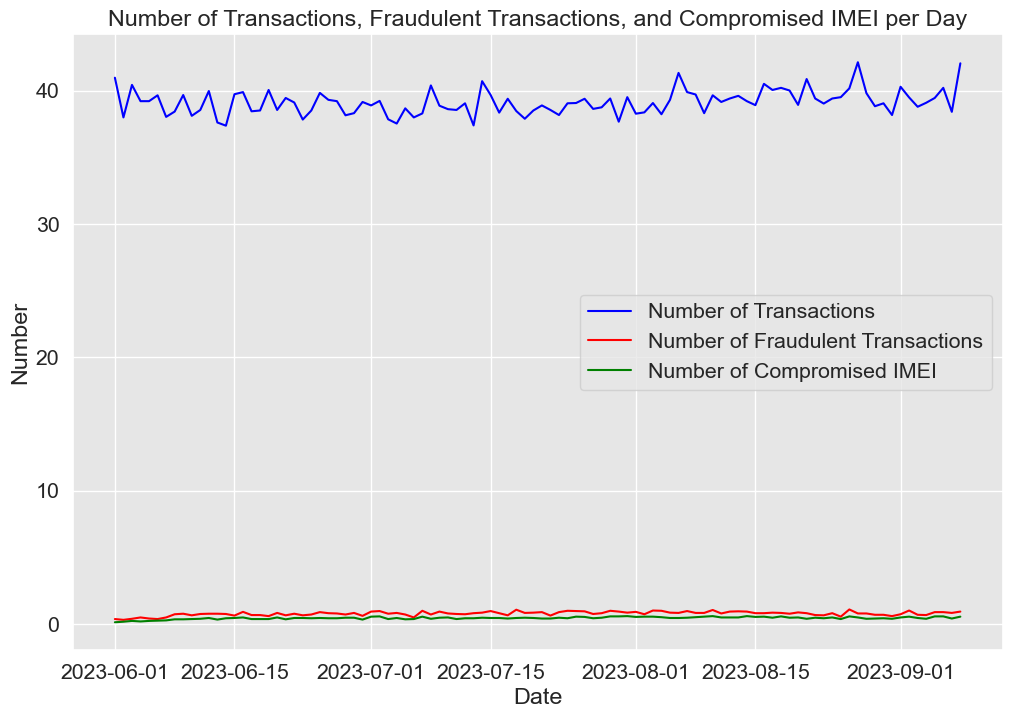

In [ ]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Number of transactions per day
plt.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, label='Number of Transactions', color='blue')

# Fraudulent transactions per day
plt.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day']/50, label='Number of Fraudulent Transactions', color='red')

# Fraudulent IMEI (compromised cards) per day
plt.plot(tx_stats['tx_date'], tx_stats['nb_compromised_imei_per_day']/50, label='Number of Compromised IMEI', color='green')

plt.title('Number of Transactions, Fraudulent Transactions, and Compromised IMEI per Day')
plt.xlabel('Date')
plt.ylabel('Number')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
start_date_training = datetime.datetime.strptime("2023-06-01", "%Y-%m-%d")

def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7):

    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]

    # Get the test set data
    test_df = []


    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].NATIONAL_ID)

    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()

    # Then, for each day of the test set
    for day in range(delta_test):

        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]

        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]

        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].NATIONAL_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)

        test_df_day = test_df_day[~test_df_day.NATIONAL_ID.isin(known_defrauded_customers)]

        test_df.append(test_df_day)

    test_df = pd.concat(test_df)

    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('REFERENCE NUMBER')
    test_df=test_df.sort_values('REFERENCE NUMBER')

    return (train_df, test_df)

In [ ]:
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

In [ ]:
train_df.shape

(13778, 18)

In [ ]:
test_df.shape

(13270, 18)

In [ ]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'NATIONAL_ID_NB_TX_1DAY_WINDOW',
       'NATIONAL_ID_AVG_AMOUNT_1DAY_WINDOW', 'NATIONAL_ID_NB_TX_7DAY_WINDOW',
       'NATIONAL_ID_AVG_AMOUNT_7DAY_WINDOW', 'NATIONAL_ID_NB_TX_30DAY_WINDOW',
       'NATIONAL_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

In [ ]:
def fit_model_and_get_predictions(classifier, train_df, test_df,
                                  input_features, output_feature="TX_FRAUD",scale=True):

    # By default, scales input data
    if scale:
        (train_df, test_df)=scaleData(train_df,test_df,input_features)

    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time

    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models,
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }

    return model_and_predictions_dictionary